In [6]:
import sys,os,time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.ndimage
from skimage.io import imread, imsave
from skimage.transform import rotate

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, IterableDataset

from utils import LARGE_CHIP_SIZE, CHIP_SIZE,CROP_POINT, NUM_WORKERS,MixedLoss, joint_transform, mixed_loss, get_mask
from tqdm import tqdm

from dataloader import AirbusShipPatchDataset, AirbusShipDataset
from streaming_dataloader import StreamingShipDataset, StreamingShipValTestDataset
import joblib

import rasterio
import fiona
import shapely.geometry
import cv2
import rasterio.features
from PIL import Image
import segmentation_models_pytorch as smp
import glob

In [2]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [3]:
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
# preprocessing_fn = None

#  Test Loader

streaming_test_dataset = StreamingShipValTestDataset("./data/test_df.csv", "./data/train_v2/", 
    large_chip_size=LARGE_CHIP_SIZE, chip_size=CHIP_SIZE, transform=joint_transform, preprocessing_fn=preprocessing_fn,
    rotation_augmentation=False, only_ships=True)

streaming_test_aug_dataset = StreamingShipValTestDataset("./data/test_df.csv", "./data/train_v2/", 
    large_chip_size=LARGE_CHIP_SIZE, chip_size=CHIP_SIZE, transform=joint_transform, preprocessing_fn=preprocessing_fn,
    rotation_augmentation=True, only_ships=True)

test_loader = DataLoader(dataset=streaming_test_dataset, batch_size = 1, num_workers=4)

test_aug_loader = DataLoader(dataset=streaming_test_aug_dataset, batch_size = 1, num_workers=4)

In [4]:
device = torch.device("cuda:%d" % 0)
aug_model = torch.load('./best_model_aug_new.pth')
aug_model = aug_model.to(device)

non_aug_model = torch.load('./best_model_non_aug.pth')
non_aug_model = non_aug_model.to(device)

In [5]:
aug_model.eval()
non_aug_model.eval()
loss = MixedLoss(10.0,2.0)
loss.__name__ = "MixedLoss"

metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

In [163]:
os.listdir

<function posix.listdir(path=None)>

In [167]:
all_img_fns = glob.glob('./data/test_set_rotation_aug/img/*')

In [169]:
all_mask_fns = glob.glob('./data/test_set_rotation_aug/mask/*')

In [170]:
len(all_img_fns) == len(all_mask_fns)

True

In [7]:
class ShipTestDataset(Dataset):

    def __init__(self, file_path, transform=None):
        self.file_path = file_path
        self.image_fns = glob.glob(self.file_path + "img/*")
        self.transform = transform

    def __len__(self):
        return len(self.image_fns)

    def __getitem__(self, idx):
        
        fn = self.image_fns[idx].split('/')[-1]
        
        mask_fn = os.path.join(self.file_path, "mask",fn.replace("jpg", "png"))
        
        # Read image
        img = imread(self.image_fns[idx])
        mask = imread(mask_fn)
        
        if self.transform:
            img = self.transform(img)
        
        return img, mask

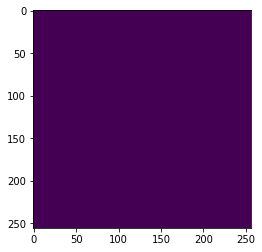

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


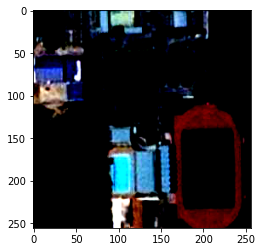

In [8]:
test_ds = ShipTestDataset('./data/test_set_rotation_aug/', transform=preprocessing_fn)
plt.figure()
plt.imshow(test_ds[0][1])
plt.show()
plt.close()
plt.figure()
plt.imshow(test_ds[0][0])
plt.show()
plt.close()